# Analyze News-Balanced Corpus

In [1]:
from rwse_checker.rwse import RWSE_Checker

import os
import spacy

/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rwse = RWSE_Checker()
nlp = spacy.load('en_core_web_sm')

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

# False-Alarm Rate

#### Determine RWSEs

In [3]:
report_file_name = 'output/report_false_positives_balanced.csv'
input_file_name = 'input/eng_news_2023_balanced-masked-sentences.csv'

result = dict()

if not os.path.exists(report_file_name):

    with open('output/false_positives_balanced.csv', 'w') as f:
        input_file = open(input_file_name, 'r')
        for line in input_file.readlines()[1:]: # skip header
            confusion_set, target, sentence = line.strip().split('\t')
            matches = 0
            rwse.set_confusion_sets([set(confusion_set.split(','))])
            suggestion, certainty = rwse.check(target, sentence)

            result.setdefault(confusion_set, {'num_sentences':0, 'num_matches':0})
            result[confusion_set]['num_sentences'] += 1
            if suggestion.lower() != target.lower(): # no case discrimination in RWSE result
                result[confusion_set]['num_matches'] += 1
                print(f'{target} => {suggestion}' ,f'({certainty:.5f})' , sentence, sep='\t', file=f)

    with open(report_file_name, 'w') as f:
        print('confusion_set', 'num_matches', 'num_sentences', sep=';', file=f)
        for key in sorted(result.keys()):
            print(key, result[key]['num_matches'], result[key]['num_sentences'], sep=';', file=f)
else:
    with open(report_file_name, 'r') as f:
        for line in f.readlines()[1:]:
            confusion_set, num_matches, num_sentences = line.strip().split(';')
            result[confusion_set] = {'num_matches': int(num_matches), 'num_sentences': int(num_sentences)}


#### Determine false-positive rate

In [4]:
total = sum(item['num_sentences'] for item in result.values())
total_matches = sum(item['num_matches'] for item in result.values())
print(f'false positive rate: {total_matches/total:.3f}')
print(f'falsely identified {total_matches} out of {total}')

false positive rate: 0.011
falsely identified 168 out of 15454


# Miss Rate

#### Determine RWSEs

In [5]:
report_file_name = 'output/report_true_positives_balanced.csv'
input_file_name = 'input/eng_news_2023_balanced-masked-sentences.csv'

result = dict()

if not os.path.exists(report_file_name):

    header = ['confusion_set', 'expected', 'target', 'suggestion', 'masked_sentence']
    file_false_negatives = open('output/false_negatives_balanced.csv', 'w')
    print(*header, sep='\t', file=file_false_negatives)
    file_misclassified_positives =  open('output/misclassified_positives_balanced.csv', 'w')
    print(*header, sep='\t', file=file_misclassified_positives)

    input_file = open(input_file_name, 'r')
    for line in input_file.readlines()[1:]: # skip header
        confusion_set, expected, sentence = line.strip().split('\t')
        rwse.set_confusion_sets([set(confusion_set.split(','))])
        result.setdefault(confusion_set, {'num_sentences':0, 'num_matches':0})
        for target in confusion_set.split(','):
            if target != expected: # analyze mistakes only
                suggestion, certainty = rwse.check(target, sentence)
                result[confusion_set]['num_sentences'] += 1

                if suggestion.lower() == expected.lower(): # no case discrimination in RWSE result, true positive
                    result[confusion_set]['num_matches'] += 1
                elif suggestion.lower() == target.lower(): # false negative
                    print(confusion_set, expected, target, suggestion, sentence, sep='\t', file=file_false_negatives)
                else: # complete misclassification
                    print(confusion_set, expected, target, suggestion, sentence, sep='\t', file=file_misclassified_positives)

    file_false_negatives.close()
    file_misclassified_positives.close()

    with open(report_file_name, 'w') as f:
        print('confusion_set', 'num_matches', 'num_sentences', sep=';', file=f)
        for key in sorted(result.keys()):
            print(key, result[key]['num_matches'], result[key]['num_sentences'], sep=';', file=f)
else:
    with open(report_file_name, 'r') as f:
        for line in f.readlines()[1:]:
            confusion_set, num_matches, num_sentences = line.strip().split(';')
            result[confusion_set] = {'num_matches': int(num_matches), 'num_sentences': int(num_sentences)}

#### Determine Miss Rate

In [6]:
total = sum(item['num_sentences'] for item in result.values())
total_matches = sum(item['num_matches'] for item in result.values())
print(f'miss rate: {(1 - total_matches/total):.3f}')
print(f'missed {total - total_matches} out of {total}')

miss rate: 0.044
missed 1784 out of 40400


# Total Results

In [5]:
from helper import calculate_accuracy, calculate_miss_rate, calculate_false_alarm_rate

file_false_positives = 'output/report_false_positives_balanced.csv'
file_true_positives = 'output/report_true_positives_balanced.csv'

far = calculate_false_alarm_rate(file_false_positives)
mr = calculate_miss_rate(file_true_positives)
acc = calculate_accuracy(file_false_positives, file_true_positives)

print(f"false alarm rate: {far:.3f}") #false alarm rate: 0.001
print(f"miss rate: {mr:.3f}") #miss rate: 0.005
print(f"accuracy: {acc:.3f}") #accuracy: 0.965

false alarm rate: 0.011
miss rate: 0.044
accuracy: 0.965


# Figure

In [1]:
from helper import calculate_miss_rate, calculate_false_alarm_rate, normalize_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
report_file_name = 'output/report_true_positives_balanced.csv'
data_tpr = normalize_report(report_file_name)
miss_rate = calculate_miss_rate(report_file_name)

report_file_name = 'output/report_false_positives_balanced.csv'
data_fpr = normalize_report(report_file_name)
false_alarm_rate = calculate_false_alarm_rate(report_file_name)

In [3]:
renamed_labels_dict = {
"Being,begin,being":r"begin,\underline{b}eing",
"Capital,Capitol,capital":r"\underline{c}apital,Capitol",
"Country,County,country,county":r"\underline{c}ountry,\underline{c}ounty",
"Desert,desert,dessert":r"\underline{d}esert,\underline{d}essert",
"Easy,ease,easy":r"ease,\underline{e}asy",
"Effect,affect,effect":r"affect,\underline{e}ffect",
"Effects,affects,effects":r"affects,\underline{e}ffects",
"Except,accept,except":r"accept,\underline{e}xcept",
"Few,View,few,view":r"\underline{f}ew,\underline{v}iew",
"Form,From,form,from":r"\underline{f}orm,\underline{f}rom",
"Found,Fund,found,fund":r"\underline{f}ound,\underline{f}und",
"Fourth,forth,fourth":r"forth,\underline{f}ourth",
"Hole,Whole,hole,whole":r"\underline{h}ole,\underline{w}hole",
"Lead,Led,lead,led":r"\underline{l}ead,\underline{l}ed",
"Life,Live,life,live":r"\underline{l}ife,\underline{l}ive",
"Mad,Made,mad,made":r"\underline{m}ad,\underline{m}ade",
"Or,or,ore":r"\underline{o}r,ore",
"Past,passed,past":r"passed,\underline{p}ast",
"Peace,Piece,peace,piece":r"\underline{p}eace,\underline{p}iece",
"Plain,plain,plane":r"\underline{p}lain,plane",
"Principal,principal,principle":r"\underline{p}rincipal,principle",
"Provence,Province,province":r"Provence,\underline{p}rovince",
"Quiet,Quite,quiet,quite":r"\underline{q}uiet,\underline{q}ite",
"Rise,raise,rise":r"raise,\underline{r}ise",
"Safe,Save,safe,save":r"\underline{s}afe,\underline{s}ave",
"Site,sight,site":r"\underline{s}ite,sight",
"Split,spit,split":r"spit,\underline{s}plit",
"Than,Then,than,then":r"\underline{t}han,\underline{t}hen",
"Their,There,They,their,there,they":r"\underline{t}heir,\underline{t}here,\underline{t}hey",
"Them,Theme,them,theme":r"\underline{t}hem,\underline{t}heme",
"Things,things,thinks":r"\underline{t}hings,\underline{t}hinks",
"Three,Tree,three,tree":r"\underline{t}hree,\underline{t}ree",
"To,Too,Two,to,too,two":r"\underline{t}o,\underline{t}oo,\underline{t}wo",
"Trail,Trial,trail,trial":r"\underline{t}rail,\underline{t}rial",
"Weather,Whether,weather,whether":r"\underline{w}eather,\underline{w}ether",
"Week,weak,week":r"weak,\underline{w}eek",
"Were,Where,were,where":r"\underline{w}ere,\underline{w}here",
"Which,Witch,which,witch":r"\underline{w}hich,\underline{w}itch",
"With,width,with":r"width,\underline{w}ith",
"Word,World,word,world":r"\underline{w}ord,\underline{w}orld",
"You,Your,you,your":r"\underline{y}ou,\underline{y}our",
}


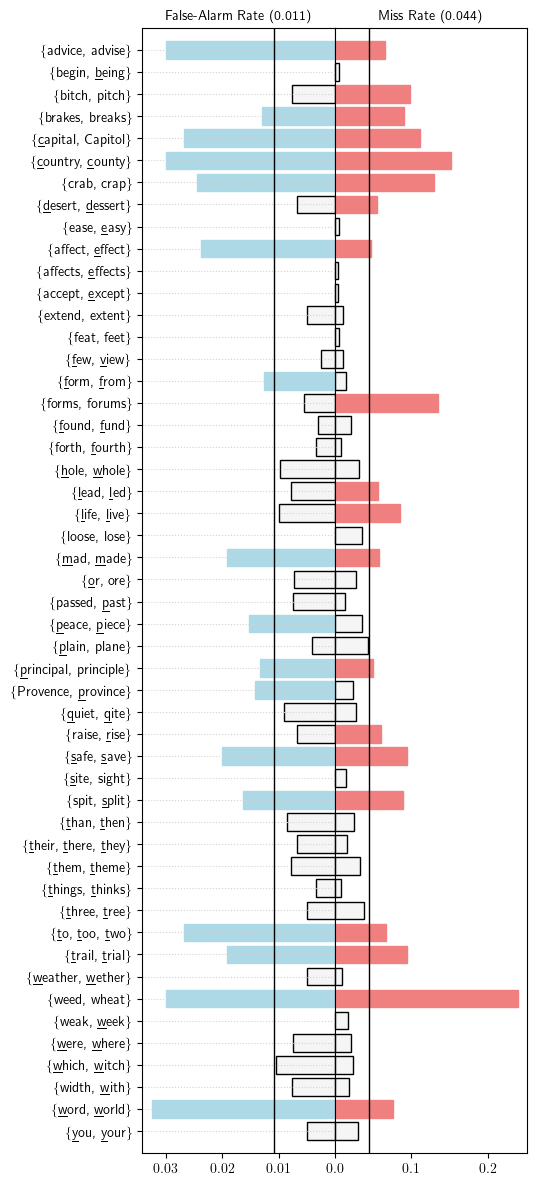

In [4]:
org_labels = sorted(data_tpr.keys(), key=lambda s: s.lower())
org_labels.reverse()

fnr_values = [1 - data_tpr[key] for key in org_labels]

fpr_values = [data_fpr[key] for key in org_labels]

data = pd.DataFrame(data={'fnr':fnr_values,
                          'fpr':fpr_values,}, index=org_labels)

font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_fpr = 'lightblue'
color_fnr = 'lightcoral'
index = [renamed_labels_dict.get(item) if renamed_labels_dict.get(item) is not None else item for item in data.index]
index = ['\{' + value.replace(',',', ') + '\}' for value in index]
column0 = data['fpr']
column1 = data['fnr']
title0 = 'False-Alarm Rate'
title1 = 'Miss Rate'

plt.rc('text', usetex=True)

fig, axes = plt.subplots(figsize=(5,15), ncols=2, sharey=True)
fig.tight_layout() #adjusts subplot params so that subplots are nicely fit in the figure

# False Alarm Rate
bars = axes[0].barh(index, column0, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(fpr_values):
    if value > false_alarm_rate:
        bars[idx].set_color(color_fpr)

axes[0].set_title(f"False-Alarm Rate ({false_alarm_rate:.3f})", fontsize=10)
axes[0].invert_xaxis()
axes[0].yaxis.tick_left()
axes[0].margins(y=0) # removes whitespace from plot edges on y-axis
axes[0].set_xticks([0.01, 0.02, 0.03])
axes[0].grid(axis = 'y', color='lightgray', linestyle='dotted')

x = [false_alarm_rate]*len(index)
y = np.linspace(-1, len(index))
axes[0].plot(x, y, zorder=3, color="black", linewidth=1)

# Miss rate
bars = axes[1].barh(index, column1, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(fnr_values):
    if value > miss_rate:
        bars[idx].set_color(color_fnr)

axes[1].set_title(f"Miss Rate ({miss_rate:.3f})", fontsize=10)
axes[1].set(yticks=index, yticklabels=index)
axes[1].tick_params(axis='y', colors='white')
axes[1].yaxis.tick_right()

x = [miss_rate]*len(index)
y = np.linspace(-1, len(index))
axes[1].plot(x, y, zorder=3, color="black", linewidth=1)

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)

